In [210]:
import os

import numpy as np

from reproject import reproject_interp

from regions import RectangleSkyRegion

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.visualization.wcsaxes import add_scalebar

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as pe

In [211]:
def plot():

    def rotate_wcs(wcs, angle):

        '''
        Rotates a WCS projection by some angle

        Parameters:

            wcs : astropy.wcs.wcs.WCS
                The original WCS projection

            angle : int
                The angle (in degrees) to rotate the WCS projection

        Returns:

            rotated_wcs : astropy.wcs.wcs.WCS
                The rotated WCS projection
        '''

        # Define the rotation angle
        angle = Angle(angle, unit='deg')

        # Get the CD matrix from the original WCS projection
        cd_matrix = wcs.wcs.cd

        # Calculate the rotation matrix
        cos_angle = np.cos(angle.rad)
        sin_angle = np.sin(angle.rad)
        rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]], dtype=np.float64)

        # Apply the rotation to the CD matrix
        rotated_cd_matrix = np.dot(cd_matrix, rotation_matrix)

        # Update the CD matrix in the rotated WCS projection
        rotated_wcs = wcs.deepcopy()
        rotated_wcs.wcs.cd = rotated_cd_matrix

        return rotated_wcs

    # Dictionary containing information about the position, orientation,
    # and style of the slit apertures
    slits = {
        'M5' : ['15:50:01.1649 -78:11:07.822', 0.85, 313, 'dashed'],
        'M4' : ['15:50:04.9279 -78:10:59.032', 0.85, 0, 'dashed'],
        'M6' : ['15:50:06.6389 -78:10:57.412', 0.85, 12, 'dashed'],
        'M3' : ['15:50:00.6009 -78:11:09.912', 0.85, 298, 'dashed'],
        'M0' : ['15:50:04.4759 -78:10:59.652', 1.0, 349, 'solid'],
        'M2' : ['15:49:59.7480 -78:11:13.482', 0.85, 52, 'solid'],
        'M7' : ['15:50:07.3959 -78:10:56.962', 0.85, 0, 'solid'],
        'M8' : ['15:49:59.9499 -78:11:12.242', 0.85, 330, 'solid'],
        'M9' : ['15:50:00.3719 -78:11:10.512', 0.85, 302, 'solid']
    }

    arc_labels = np.array(['N', 'NW'], dtype=str)
    filter_labels = np.array(['Lyα (F555W)', 'Lyα (F390W)', 'F275W'], dtype=str)

    # Establish common directories
    home = os.getcwd()
    data = f'{home}/data'
    figs = f'{home}/figs'
    results = f'{home}/results'

    hst_f275w_file = f'{data}/hst/V5.0_PSZ1G311.65-18.48_F275W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits'
    hst_f606w_file = f'{data}/hst/V5.0_PSZ1G311.65-18.48_F606W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits'
    lya_nb_f390w_file = f'{results}/Lya_cont_sub_F390W.fits'
    lya_nb_f555w_file = f'{results}/Lya_cont_sub_F555W.fits'

    files = np.array([lya_nb_f555w_file, lya_nb_f390w_file, hst_f275w_file], dtype=str)

    # Position, dimensions, and orientations of the boxes defining the areas of the inset, zoom-in axes, 
    # defined in pixel coordinates of the HST F606W observation's WCS projection
    center_n = (4591, 5303)
    center_nw = (5093, 4944)
    width, height = 464, 86
    angle_n = -19 
    angle_nw = -48 

    centers = [center_n, center_nw]
    angles = [-19, -48]

    # Get the WCS projection of the HST F606W observations
    hst_f606w_wcs = WCS(fits.getheader(hst_f606w_file))

    wcs_systems = []

    for i, angle in enumerate(angles):

        wcs_rotated = rotate_wcs(hst_f606w_wcs, angle)

        wcs_systems = np.append(wcs_systems, wcs_rotated)

    fig, ax = plt.subplots(6,1, figsize=(10,10*516/464))

    for i, file in enumerate(files):

        data = fits.getdata(file)

        #wcs = WCS(fits.getheader(file))

        for j, axes in enumerate([ax[0 + i], ax[3 + i]]):

            #wcs_rotated = rotate_wcs(wcs, angles[j])

            #print(repr(wcs_rotated))

            data_rotated, _ = reproject_interp((data, hst_f606w_wcs), wcs_systems[j], (100,100))

            axes = plt.subplot(611 + 3 * j + i, projection=wcs_systems[j])

            axes.imshow(data_rotated, origin='lower', cmap='Greys', norm=LogNorm(vmin=0.001 * np.abs(np.nanmedian(data_rotated)), vmax=10 * np.abs(np.nanmedian(data_rotated))), 
                interpolation='none')

            center = wcs_systems[j].world_to_pixel_values([hst_f606w_wcs.pixel_to_world_values([[*centers[j]]])[0]])[0]

            axes.set_xlim(center[0] - width/2, center[0] + width/2)
            axes.set_ylim(center[1] - height/2, center[1] + height/2)

            for k, coord_ax in enumerate([*axes.coords]):

                # Disable the ticks, tick labels, and axis label of the cordinate axis
                coord_ax.set_ticks_visible(False)
                coord_ax.set_ticklabel_visible(False)
                coord_ax.set_axislabel('')

            arc_label = axes.annotate(arc_labels[j], xy=(0.01, 1 - 0.01 * 464 / 86), xycoords='axes fraction', ha='left', va='top', fontsize=10, fontweight='bold')

            filter_label = axes.annotate(filter_labels[i], xy=(0.99, 1 - 0.01 * 464 / 86), xycoords='axes fraction', ha='right', va='top', fontsize=10, fontweight='bold')

            # Add an outline around the labels to make them easier to read
            arc_label.set_path_effects([pe.withStroke(linewidth=1, foreground='white')])
            filter_label.set_path_effects([pe.withStroke(linewidth=1, foreground='white')])

            add_scalebar(axes, 1 * u.arcsecond, label='1\'\'', corner='bottom left')#, fontsize=4)

            # For each slit aperture ID
            for k, slit_id in enumerate(slits):

                # Instantiate the slit as a RectangleSkyRegion
                slit_region = RectangleSkyRegion(center=SkyCoord(slits[slit_id][0], unit=(u.hourangle, u.deg), frame='fk5'), 
                    width=slits[slit_id][1] * u.arcsecond, height=10 * u.arcsecond, angle=slits[slit_id][2] * u.deg)

                # Convert the slit region object to a pixel-based representation
                slit_region_pxl = slit_region.to_pixel(wcs_systems[j])
    
                # Plot the slit region on the axes
                slit_region_pxl.plot(ax=axes, color='#D41159', lw=1, linestyle=slits[slit_id][3])

    fig.savefig(f'{figs}/lya_and_lyc_maps.pdf', bbox_inches='tight')

C:\Users\15136\AppData\Local\Temp/ipykernel_17428/2738477820.py:110: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes = plt.subplot(611 + 3 * j + i, projection=wcs_systems[j])
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\15136\AppData\Local\Programs\Python\Python39\lib\site-packages\regions\shapes\rectangle.py:201: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Rectangle(xy=xy, width=width, height=height,


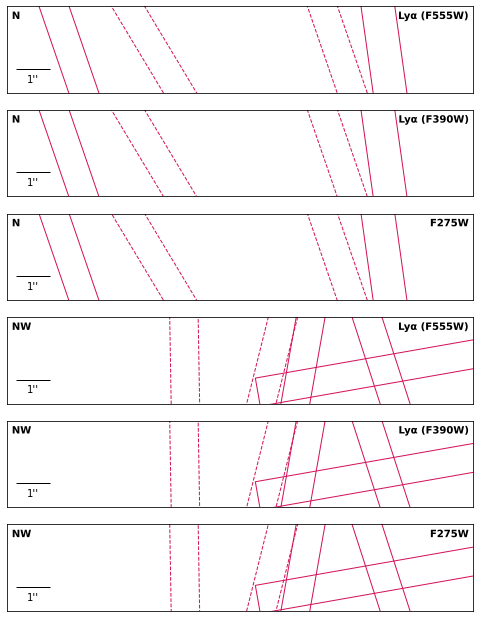

In [212]:
plot()